# Customer segmentation using RFM features and K-means algortihm
### Author: Pavel Novotný

Dataset: sales-order and sales-order-item records from 01/1/2020 - 31/12/2020

Last updated at: 14. 03. 2022

## Data loading & packages import

In [4]:
#pip install plotly

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from datetime import timedelta
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn import metrics
from numpy import percentile
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from kneed import KneeLocator
import matplotlib.cm as cm
import matplotlib.style as style

pd.set_option('display.max_columns', None)

sales_order = pd.read_csv('in/tables/sales-order.csv_2', dtype = object)
sales_order_item = pd.read_csv('in/tables/sales-order-item.csv_2', dtype = object)
#customer = pd.read_csv('in/tables/customer-entity.csv_2', dtype = object)
#katalog = pd.read_csv('in/tables/katalog.csv', dtype = object)
#product_list = pd.read_csv('in/tables/product-list.csv_2', dtype = object)

## Data preparation


### Keep only orders with status complete + only configurable items + only B2C customer groups

In [2]:
sales_order = sales_order.loc[sales_order['created_at']>='2020-01-01']
sales_order_item = sales_order_item.loc[sales_order_item['created_at']>='2020-01-01']

sales_order = sales_order.loc[sales_order['status']=='complete']
sales_order = sales_order.loc[sales_order['customer_group_id'].isin(['0','1'])]
sales_order_item = sales_order_item.loc[sales_order_item['product_type']=='configurable']


sales_order.head()

,entity_id,customer_email,status,store_id,base_subtotal,base_currency_code,base_to_global_rate,global_currency_code,order_discount_type,customer_is_guest,customer_group_id,shipping_method,store_name,created_at,updated_at,total_item_count,customer_gender
0,3522514,856e9196a47de0b456cb04e3cb6ab285,complete,1,16.5800,EUR,1.0000,EUR,no discount,1,0,gls_delivery_delivery,GymBeamSk\nGymBeamSk\nGymBeamSk,2020-04-13 13:21:43,2020-04-18 14:34:51,2,NaN
3,3524998,a9bda29de52e88427c4573b27ec87530,complete,1,7.4600,EUR,1.0000,EUR,no discount,1,0,slovakpost_pickup,GymBeamSk\nGymBeamSk\nGymBeamSk,2020-04-13 16:12:54,2020-04-18 14:39:12,2,NaN
31,5740423,2f9686557d6e1028bedcaf4dd6d4fe35,complete,4,95.3200,RON,0.2052,EUR,no discount,1,0,dpd_delivery,GymBeamRo\nGymBeamRo\nGymBeamRo,2020-11-20 15:17:29,2020-11-27 17:35:20,5,NaN
32,3911866,599e5d134e1ba599c304d810ce7b0a4c,complete,1,34.7300,EUR,1.0000,EUR,no discount,1,0,slovakpost_pickup,GymBeamSk\nGymBeamSk\nGymBeamSk,2020-05-17 08:45:04,2020-05-20 14:37:44,7,NaN
33,3912301,7a1d668b861560459bc66c99695c8a08,complete,1,28.1700,EUR,1.0000,EUR,no discount,0,1,slovakpost_pickup,GymBeamSk\nGymBeamSk\nGymBeamSk,2020-05-17 09:01:03,2020-05-20 14:37:43,3,NaN


### Rename ID columns to avoid confusion

In [3]:
sales_order.rename(columns={'entity_id':'sales_order_id'},inplace=True)

sales_order_item.head()

,item_id,order_id,parent_item_id,store_id,created_at,updated_at,product_id,product_type,weight,sku,name,qty_ordered,price,base_price,item_discount_type,base_row_total,free_shipping
0,41888722,6052090,NaN,2,2020-12-13 16:22:24,2020-12-15 16:36:24,29663,configurable,0.4000,29663-1,Bezkalorický sirup Salted Caramel 350 ml - Gym...,1.0000,77.3900,77.3900,no discount,77.3900,0
2,41913337,6055438,NaN,2,2020-12-13 20:27:54,2020-12-16 11:58:12,34210,configurable,0.1450,34207-1-orange-lemon-cherry-60caps,Multivitamin Yummies - GymBeam,2.0000,138.2600,138.2600,no discount,276.5200,0
5,41902585,6054142,NaN,2,2020-12-13 19:02:11,2020-12-16 11:49:47,30212,configurable,0.1700,30212-4-xl,Tričko Walk In Strong White - GymBeam,1.0000,114.8800,114.8800,no discount,114.8800,0
6,41881150,6051079,NaN,3,2020-12-13 14:47:31,2020-12-15 16:41:01,1730,configurable,0.2010,1731-1731-100 tab,L-Karnitin TABS 100 tabl - GymBeam,1.0000,2669.2900,2669.2900,no discount,2669.2900,0
7,41917579,6056005,NaN,3,2020-12-13 21:10:14,2020-12-15 16:41:10,29655,configurable,0.2760,29655-1-250,100% MCT Oil Powder - GymBeam,1.0000,1929.1300,1929.1300,no discount,1929.1300,0


In [4]:
sales_order_item.shape

(3960847, 17)

### Merge sales_order with sales_order_item

In [5]:
sales = sales_order.merge(sales_order_item,left_on='sales_order_id',right_on='order_id')
sales.head()

,sales_order_id,customer_email,status,store_id_x,base_subtotal,base_currency_code,base_to_global_rate,global_currency_code,order_discount_type,customer_is_guest,customer_group_id,shipping_method,store_name,created_at_x,updated_at_x,total_item_count,customer_gender,item_id,order_id,parent_item_id,store_id_y,created_at_y,updated_at_y,product_id,product_type,weight,sku,name,qty_ordered,price,base_price,item_discount_type,base_row_total,free_shipping
0,3522514,856e9196a47de0b456cb04e3cb6ab285,complete,1,16.5800,EUR,1.0000,EUR,no discount,1,0,gls_delivery_delivery,GymBeamSk\nGymBeamSk\nGymBeamSk,2020-04-13 13:21:43,2020-04-18 14:34:51,2,NaN,22755856,3522514,NaN,1,2020-04-13 13:21:43,2020-04-18 14:34:51,28959,configurable,0.1650,28959-3-l,Tričko Free Your Strength Maroon White - GymBeam,1.0000,8.2900,8.2900,no discount,8.2900,0
1,3522514,856e9196a47de0b456cb04e3cb6ab285,complete,1,16.5800,EUR,1.0000,EUR,no discount,1,0,gls_delivery_delivery,GymBeamSk\nGymBeamSk\nGymBeamSk,2020-04-13 13:21:43,2020-04-18 14:34:51,2,NaN,22755850,3522514,NaN,1,2020-04-13 13:21:43,2020-04-18 14:34:51,29368,configurable,0.1660,29368-3-l,Tričko Make Muscles Heather Purple - GymBeam,1.0000,8.2900,8.2900,no discount,8.2900,0
2,3524998,a9bda29de52e88427c4573b27ec87530,complete,1,7.4600,EUR,1.0000,EUR,no discount,1,0,slovakpost_pickup,GymBeamSk\nGymBeamSk\nGymBeamSk,2020-04-13 16:12:54,2020-04-18 14:39:12,2,NaN,22775440,3524998,NaN,1,2020-04-13 16:12:55,2020-04-18 14:39:12,28132,configurable,0.4350,28132-1-hazelnut-cacao,Proteinella - HealthyCo,1.0000,7.4600,7.4600,no discount,7.4600,0
3,5740423,2f9686557d6e1028bedcaf4dd6d4fe35,complete,4,95.3200,RON,0.2052,EUR,no discount,1,0,dpd_delivery,GymBeamRo\nGymBeamRo\nGymBeamRo,2020-11-20 15:17:29,2020-11-27 17:35:20,5,NaN,39474016,5740423,NaN,4,2020-11-20 15:17:29,2020-11-27 17:35:20,6860,configurable,0.5220,6860-1-agave,Sirop de agave BIO 250 ml - GymBeam,1.0000,13.2100,13.2100,no discount,13.2100,0
4,5740423,2f9686557d6e1028bedcaf4dd6d4fe35,complete,4,95.3200,RON,0.2052,EUR,no discount,1,0,dpd_delivery,GymBeamRo\nGymBeamRo\nGymBeamRo,2020-11-20 15:17:29,2020-11-27 17:35:20,5,NaN,39474004,5740423,NaN,4,2020-11-20 15:17:29,2020-11-27 17:35:20,37066,configurable,0.4440,37054-2-400g-dreamy-hazelnut,Proteinela - GymBeam,2.0000,17.3400,17.3400,no discount,34.6800,0


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338138 entries, 0 to 3338137
Data columns (total 34 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   sales_order_id        object
 1   customer_email        object
 2   status                object
 3   store_id_x            object
 4   base_subtotal         object
 5   base_currency_code    object
 6   base_to_global_rate   object
 7   global_currency_code  object
 8   order_discount_type   object
 9   customer_is_guest     object
 10  customer_group_id     object
 11  shipping_method       object
 12  store_name            object
 13  created_at_x          object
 14  updated_at_x          object
 15  total_item_count      object
 16  customer_gender       object
 17  item_id               object
 18  order_id              object
 19  parent_item_id        object
 20  store_id_y            object
 21  created_at_y          object
 22  updated_at_y          object
 23  product_id            object
 24

### Rename duplicate columns, drop unnecessary columns, convert respective data types to float and datetime

In [7]:
sales.drop(columns=['free_shipping','item_discount_type','updated_at_y','created_at_y','store_id_y','weight','shipping_method','customer_is_guest','order_discount_type'],inplace=True)
sales.rename(columns={'created_at_x':'order_created_at', 'store_id_x': 'store_id'},inplace=True)

sales['order_created_at'] = pd.to_datetime(sales['order_created_at'])
sales['price'] = sales['price'].astype(float)
sales['base_price'] = sales['base_price'].astype(float)
sales['qty_ordered'] = sales['qty_ordered'].astype(float)
sales['base_row_total'] = sales['base_row_total'].astype(float)
sales['base_to_global_rate'] = sales['base_to_global_rate'].astype(float)

#convert local currency to EUR
sales['global_row_total'] = sales['base_row_total']*sales['base_to_global_rate']

### Create dataframe with total spent per each customer and order

In [8]:
df_customer_order = pd.pivot_table(sales, values='global_row_total', index=['customer_email','sales_order_id'], aggfunc=np.sum)
df_customer_order.head(10)

global_row_total
customer_email                   sales_order_id                  
000015f7fef778f5f33d05a9119fdffa 4461679                49.937020
00004bf1baa83136f53fd4576c9356b7 2703733                32.256000
00005bda245abefd40c464a4e8179bb4 3298726                50.774808
0000724ed6a84809e92c00d12e77affe 3318889                21.412050
000072a5e9d061b7821d641f026351f2 6156691                 5.790000
00008e5ff4d72b448ea70f624a2b1cc0 5903200               142.103618
0000a7e69cf099da1fc27789dff4b0ae 4995043                26.500000
                                 5750767                45.620000
0000bf237652d8327ebd2c39071bcfdf 4003300                 6.620000
                                 4569856                18.290000

### Delete input datasets to release memory space

In [9]:
del(sales_order_item)
del(sales_order)

### Create dataframe of customer profile and feature engineering of RFM labels

In [10]:
rfm = pd.DataFrame(df_customer_order.groupby('customer_email').agg({'global_row_total':'sum'}))
rfm.rename(columns={'global_row_total':'monetary'},inplace=True)

rfm.head()

,monetary
customer_email,
000015f7fef778f5f33d05a9119fdffa,49.937020
00004bf1baa83136f53fd4576c9356b7,32.256000
00005bda245abefd40c464a4e8179bb4,50.774808
0000724ed6a84809e92c00d12e77affe,21.412050
000072a5e9d061b7821d641f026351f2,5.790000


In [11]:
rfm['frequency'] = pd.DataFrame(df_customer_order.reset_index().groupby('customer_email').agg({'sales_order_id':'count'}))

anchor_date = dt.datetime(2021,1,1)

sorted_sales = sales.sort_values('order_created_at')
sorted_sales = pd.DataFrame(sorted_sales.drop_duplicates('customer_email', keep='last'))
sorted_sales.set_index('customer_email',inplace=True)

rfm['recency'] = anchor_date - sorted_sales['order_created_at']
rfm['recency'] = rfm['recency'] / np.timedelta64(1,'D')

### Finished RFM dataset per customer before scaling / normalization:

In [12]:
rfm.head(10)

,monetary,frequency,recency
customer_email,,,
000015f7fef778f5f33d05a9119fdffa,49.937020,1,164.183090
00004bf1baa83136f53fd4576c9356b7,32.256000,1,357.515787
00005bda245abefd40c464a4e8179bb4,50.774808,1,286.627280
0000724ed6a84809e92c00d12e77affe,21.412050,1,284.250359
000072a5e9d061b7821d641f026351f2,5.790000,1,4.537824
00008e5ff4d72b448ea70f624a2b1cc0,142.103618,1,32.102431
0000a7e69cf099da1fc27789dff4b0ae,72.120000,2,40.710058
0000bf237652d8327ebd2c39071bcfdf,34.870000,3,148.437350
0000ce759142f8cb9068f86692a3f14f,29.080000,1,353.634282


In [13]:
rfm.shape

(538883, 3)

### Another memory release

In [14]:
del(sales)
del(df_customer_order)

## Exploratory Data Analysis

### Distribution of Monetary value

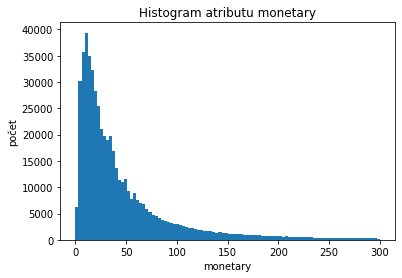

In [15]:
plt.hist(x=rfm['monetary'],bins=100,range=(0,300))
plt.title('Histogram atributu monetary')
plt.xlabel('monetary')
plt.ylabel('počet')
plt.savefig('hist_monetary_raw.png')
plt.show()

/home/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='monetary'>

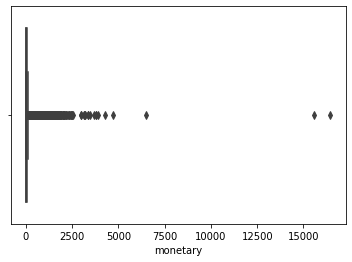

In [16]:
sns.boxplot(rfm['monetary'])

### Distribution of Frequency

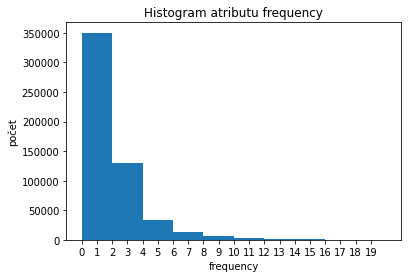

In [17]:
plt.hist(x=rfm['frequency'],bins=10,range=(0,20))
plt.xticks(np.arange(0,20,step=1))
plt.title('Histogram atributu frequency')
plt.xlabel('frequency')
plt.ylabel('počet')
plt.savefig('hist_frequency_raw.png')
plt.show()

### Distribution of Recency

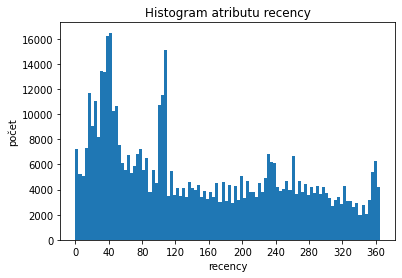

In [18]:
plt.hist(x=rfm['recency'],bins=100,range=(0,365))
plt.xticks(np.arange(0,365,step=40))
plt.title('Histogram atributu recency')
plt.xlabel('recency')
plt.ylabel('počet')
plt.savefig('hist_recency_raw.png')
plt.show()

In [19]:
rfm.describe()

,monetary,frequency,recency
count,538883.000000,538883.000000,538883.000000
mean,55.547027,1.874626,147.616203
std,94.279896,2.409645,107.173660
min,0.000000,1.000000,0.002465
25%,13.928640,1.000000,47.514624
50%,29.460000,1.000000,117.729468
75%,60.660000,2.000000,238.201418
max,16449.678084,790.000000,365.999433


### Outliers detection and removal using IQR method

In [15]:
def IQR_outlier_deletion(data):
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr)) # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x <= lower or x >= upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in data if x > lower and x < upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    return outliers_removed

In [16]:
#Function call
monetary_IQR = IQR_outlier_deletion(rfm['monetary'])

Percentiles: 25th=13.929, 75th=60.660, IQR=46.731
Identified outliers: 49736
Non-outlier observations: 489147


In [17]:
recency_IQR = IQR_outlier_deletion(rfm['recency'])

Percentiles: 25th=47.515, 75th=238.201, IQR=190.687
Identified outliers: 0
Non-outlier observations: 538883


In [18]:
frequency_IQR = IQR_outlier_deletion(rfm['frequency'])

Percentiles: 25th=1.000, 75th=2.000, IQR=1.000
Identified outliers: 58197
Non-outlier observations: 480686


In [19]:
monetary_upper = max(monetary_IQR)
monetary_lower = min(monetary_IQR)
recency_upper = max(recency_IQR)
recency_lower = min(recency_IQR)
frequency_upper = max(frequency_IQR)
frequency_lower = min(frequency_IQR)

In [20]:
rfm_IQR = rfm [ ((rfm['monetary'] <= monetary_upper) & (rfm['recency']<=recency_upper) & (rfm['frequency']<=frequency_upper)) ]
outliers = rfm.reset_index().merge(rfm_IQR, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'].set_index('customer_email')
outliers.drop(columns='_merge',inplace=True)


In [21]:
rfm_IQR.shape

(466409, 3)

### MinMaxScaler of the IQR cleared dataframe

In [21]:
# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
df_norm = pd.DataFrame(scaler.fit_transform(rfm_IQR), columns=rfm_IQR.columns).set_index(rfm_IQR.index)
df_norm.head()

,monetary,frequency,recency
customer_email,,,
000015f7fef778f5f33d05a9119fdffa,0.381914,0.0,0.448585
00004bf1baa83136f53fd4576c9356b7,0.246691,0.0,0.976820
00005bda245abefd40c464a4e8179bb4,0.388321,0.0,0.783134
0000724ed6a84809e92c00d12e77affe,0.163757,0.0,0.776640
000072a5e9d061b7821d641f026351f2,0.044281,0.0,0.012392


In [25]:
df_norm.describe()

,monetary,frequency,recency
count,466409.000000,466409.000000,466409.000000
mean,0.247818,0.159819,0.434412
std,0.202905,0.297009,0.294093
min,0.000000,0.000000,0.000000
25%,0.095216,0.000000,0.158769
50%,0.184162,0.000000,0.386922
75%,0.340332,0.500000,0.686288
max,1.000000,1.000000,1.000000


## Elbow Method: determining the number of k clusters by elbow point

Elbow point at: 5


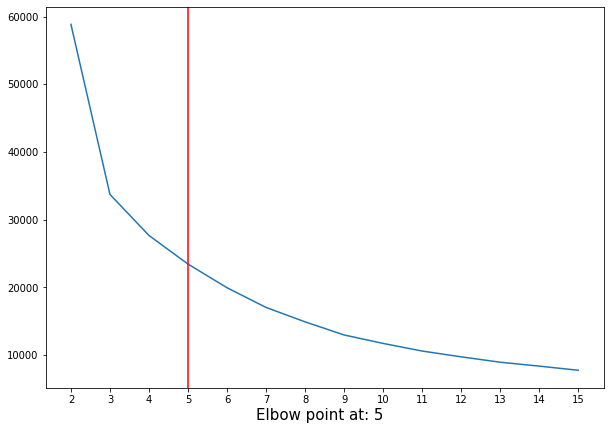

In [29]:
#!pip install kneed

n_clusters = list(range(2,16))

params = {
  "n_init": 20,
  "max_iter": 500,
  "random_state": 0,
}
# try different number of cluster, store SSE for each
sse = []
for k in n_clusters:
  km = KMeans(n_clusters=k, **params)
  km.fit(df_norm)
  sse.append(km.inertia_)

# locate the elbow point
locator = KneeLocator(
  n_clusters, sse, curve="convex", direction="decreasing"
)
elbow = locator.elbow

print(f'Elbow point at: {elbow}')

plt.figure(figsize=(10, 7))
plt.text(10,10, f'Elbow point at: {elbow}',verticalalignment='bottom', horizontalalignment='right',fontsize=15)
plt.xticks(np.arange(0,16,step=1))
sns.lineplot(x=n_clusters, y=sse)
# add the elbow point
plt.axvline(elbow, c='red')
plt.savefig('elbow.png',dpi=300)
plt.show()


## Silhouette Analysis

#### Results:
Best number of clusters (k) = 5

Avg Silhouette score for 5 clusters: 0.81

The following block of code regarding silhouette analysis was implemented with the guidance of scikit-learn example:

SCIKIT-LEARN DEVELOPERS, 2022. Selecting the number of clusters with silhouette analysis on KMeans clustering. scikit-learn [online] [vid. 2022-03-13]. Dostupné z: https://scikit-learn/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


In [ ]:
X = df_norm
range_n_clusters = [5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# kMeans: silhouette score
k = 5
model = KMeans(n_clusters=k, random_state=42, verbose=0)
clusters_assigned = model.fit_predict(df_norm)
K_sil_a3 = silhouette_score(df_norm, clusters_assigned)
print("silhouette score for", k, "clusters: " f'{K_sil_a3:.3f}')

## K-Means clustering of the normalized dataset

#### Define clustering

In [22]:
km = KMeans(
    n_clusters = 5,
    n_init = 20, # do clustering more times to diminish randomness
    max_iter = 500,
    random_state = 0,
)

km.fit(df_norm)

KMeans(max_iter=500, n_clusters=5, n_init=20, random_state=0)

#### Assign data to clusters

In [23]:
pred = km.predict(df_norm)
df_norm['cl_km'] = pred
rfm_IQR['cl_km'] = df_norm['cl_km'] #assigning clusters to the original data as well
print(pred)

[3 4 4 ... 3 4 3]


<ipython-input-23-a8c3b9dc3088>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_IQR['cl_km'] = df_norm['cl_km'] #assigning clusters to the original data as well


#### Check results

In [28]:
rfm_IQR.head()

,monetary,frequency,recency,cl_km
customer_email,,,,
000015f7fef778f5f33d05a9119fdffa,49.937020,1,164.183090,3
00004bf1baa83136f53fd4576c9356b7,32.256000,1,357.515787,4
00005bda245abefd40c464a4e8179bb4,50.774808,1,286.627280,4
0000724ed6a84809e92c00d12e77affe,21.412050,1,284.250359,4
000072a5e9d061b7821d641f026351f2,5.790000,1,4.537824,3


## Interpretation of the results

### Count of customers per cluster

In [24]:
rfm_IQR.rename(columns={'cl_km':'cluster'},inplace=True)

<ipython-input-24-371daca9b621>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_IQR.rename(columns={'cl_km':'cluster'},inplace=True)


In [25]:
df_norm.groupby('cl_km').count()

,monetary,frequency,recency
cl_km,,,
0,30275,30275,30275
1,31881,31881,31881
2,55948,55948,55948
3,179701,179701,179701
4,168604,168604,168604


In [ ]:
# vizualize
plt.figure(figsize=(20, 20))

ax = sns.scatterplot(x='recency', y='monetary', hue=rfm_IQR['cluster'], data=rfm, palette='tab10')

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='recency', y='frequency', hue=rfm['cluster'], data=rfm, palette='tab10')
plt.ylim(0,20)

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='frequency', y='monetary', hue=df_norm['cl_km'], data=df_norm, palette='tab10')

### Plot 3D scatter plot 

In [ ]:
fig = px.scatter_3d(rfm_IQR, x=rfm_IQR['recency'], y=rfm_IQR['frequency'], z=rfm_IQR['monetary'], color=rfm_IQR['cluster'] ,width=800, height=800)
fig.update_traces(marker=dict(size=2))
fig.show()

### Results description

In [56]:
rfm_IQR.groupby('cluster').describe().transpose()

cluster                     0             1             2              3  \
monetary  count  30275.000000  31881.000000  55948.000000  179701.000000   
          mean      69.267129     47.852159     52.818726      24.869904   
          std       29.562755     27.614169     29.732846      19.537482   
          min        2.829227      0.812476      0.000000       0.000000   
          25%       45.221436     26.420000     29.080000      10.500000   
          50%       66.670493     41.643686     46.750000      18.988320   
          75%       92.171576     64.120000     72.011489      33.973236   
          max      130.754733    130.670000    130.750000     117.326250   
frequency count  30275.000000  31881.000000  55948.000000  179701.000000   
          mean       3.000000      2.039585      1.990009       1.000000   
          std        0.000000      0.200692      0.099457       0.000000   
          min        3.000000      1.000000      1.000000       1.000000   
          25%        3.000000      2.000000      2.000000       1.000000   
          50%        3.000000      2.000000      2.000000       1.000000   
          75%        3.000000      2.000000      2.000000       1.000000   
          max        3.000000      3.000000      2.000000       1.000000   
recency   count  30275.000000  31881.000000  55948.000000  179701.000000   
          mean      94.329118    242.105374     67.720816      77.499039   
          std       71.648024     53.017387     40.888493      47.265638   
          min        0.003275    146.331574      0.011262       0.002465   
          25%       37.481071    199.224144     34.594442      37.243530   
          50%       76.737963    236.736829     59.357749      72.297315   
          75%      135.072720    281.476042    103.522176     110.662454   
          max      343.694016    365.566308    176.960231     177.190729   

cluster                      4  
monetary  count  168604.000000  
          mean       24.117645  
          std        19.729767  
          min         0.000000  
          25%         9.960000  
          50%        18.025692  
          75%        32.747520  
          max       130.710000  
frequency count  168604.000000  
          mean        1.000000  
          std         0.000000  
          min         1.000000  
          25%         1.000000  
          50%         1.000000  
          75%         1.000000  
          max         1.000000  
recency   count  168604.000000  
          mean      272.041557  
          std        54.596855  
          min       174.151181  
          25%       228.533513  
          50%       268.543588  
          75%       318.255998  
          max       365.999433

In [27]:
output = rfm_IQR[['cluster']].reset_index(drop=False)

In [29]:
output.to_csv('out/tables/segmentation_train.csv', index = False)